In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

In [2]:
# Load the zip file
df = pd.read_csv('snp_beta_macd_signal_rsi.zip', compression='zip')
df.head()

,Stock,2014-05-01 00:00:00,2014-05-02 00:00:00,2014-05-05 00:00:00,2014-05-06 00:00:00,2014-05-07 00:00:00,2014-05-08 00:00:00,2014-05-09 00:00:00,2014-05-12 00:00:00,2014-05-13 00:00:00,...,2024-04-24 00:00:00,2024-04-25 00:00:00,2024-04-26 00:00:00,2024-04-29 00:00:00,2024-04-30 00:00:00,Industry,Beta,MACD,Signal,RSI
0,A,35.818909,35.864948,36.384441,36.174015,36.187160,36.364704,36.423893,37.094631,37.370804,...,137.490005,136.369995,137.740005,139.589996,137.039993,Diagnostics & Research,1.126,-1.536634,-1.509291,45.444335
1,AAL,34.306366,34.400639,34.504337,34.570320,35.088844,36.059853,36.069294,37.134579,37.059177,...,13.920000,14.130000,13.880000,13.980000,13.510000,Airlines,1.580,-0.129848,-0.153215,39.044930
2,AAPL,18.581390,18.615952,18.879210,18.673439,18.608089,18.574923,18.497526,18.727819,18.757200,...,168.791061,169.659882,169.070679,173.264984,170.099289,Consumer Electronics,1.264,-0.861375,-1.433049,52.048345
3,ABBV,34.194000,33.909100,34.028362,33.730228,34.975811,34.551777,34.624657,34.697540,34.584908,...,167.800003,167.289993,159.619995,161.520004,162.639999,Drug Manufacturers - General,0.593,-2.645659,-2.440588,39.560258
4,ABNB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,162.839996,163.009995,164.229996,162.250000,158.570007,Travel Services,1.246,0.133508,0.029556,43.219668


#### Delete additional rows added for RSI, MACD values

In [3]:
# Delete rows with Stock name containin '_'
df = df[~df['Stock'].str.contains('_')]
df.shape

(503, 2523)

#### Get Additional Data like PE, Earnings_Growth, Volatility, etc. from Yahoo Finance

In [4]:
# Function to calculate historical volatility based on annualized standard deviation of returns
# returns are calculated as percentage change in closing prices
def calculate_volatility(ticker):
    stock = yf.Ticker(ticker)
    hist = stock.history(period='max') # Max period available
    returns = hist['Close'].pct_change().dropna() # percentage change in closing prices
    if len(returns) == 0:
        return None
    volatility = np.std(returns) * np.sqrt(252)  # Annualized volatility
    return volatility

In [5]:
# Function to fetch other financial data for a given ticker
def fetch_financial_data(ticker):
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        volatility = calculate_volatility(ticker) # Calculate volatility for last 1y
        
        return {
            'PE_Ratio': info.get('trailingPE', None),
            'EPS': info.get('trailingEps', None),
            'Earnings_Growth': info.get('earningsQuarterlyGrowth', None),
            'Volatility': volatility,
            'Market_Cap': info.get('marketCap', None),
            'Debt_to_Equity': info.get('debtToEquity', None),
            'Dividend_Yield': info.get('dividendYield', None)
        }
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return {
            'PE_Ratio': None,
            'EPS': None,
            'Earnings_Growth': None,
            'Volatility': None,
            'Market_Cap': None,
            'Debt_to_Equity': None,
            'Dividend_Yield': None
        }

In [6]:
# Apply the function to each ticker in the DataFrame
financial_data = df['Stock'].apply(fetch_financial_data)
financial_df = pd.DataFrame(financial_data.tolist())

# Merge the financial data with the original DataFrame
df = pd.concat([df, financial_df], axis=1)

# Display the updated DataFrame
print(df)

/tmp/ipykernel_66034/2492635859.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = hist['Close'].pct_change().dropna() # percentage change in closing prices


    Stock  2014-05-01 00:00:00  2014-05-02 00:00:00  2014-05-05 00:00:00  \
0       A            35.818909            35.864948            36.384441   
1     AAL            34.306366            34.400639            34.504337   
2    AAPL            18.581390            18.615952            18.879210   
3    ABBV            34.194000            33.909100            34.028362   
4    ABNB                  NaN                  NaN                  NaN   
..    ...                  ...                  ...                  ...   
498   XYL            32.479702            32.391838            32.312733   
499   YUM            45.543854            45.513985            45.573730   
500   ZBH            87.445427            87.992554            88.817650   
501  ZBRA            70.529999            71.919998            72.199997   
502   ZTS            28.207462            28.514559            28.412199   

     2014-05-06 00:00:00  2014-05-07 00:00:00  2014-05-08 00:00:00  \
0              36

In [7]:
df.head()

,Stock,2014-05-01 00:00:00,2014-05-02 00:00:00,2014-05-05 00:00:00,2014-05-06 00:00:00,2014-05-07 00:00:00,2014-05-08 00:00:00,2014-05-09 00:00:00,2014-05-12 00:00:00,2014-05-13 00:00:00,...,MACD,Signal,RSI,PE_Ratio,EPS,Earnings_Growth,Volatility,Market_Cap,Debt_to_Equity,Dividend_Yield
0,A,35.818909,35.864948,36.384441,36.174015,36.187160,36.364704,36.423893,37.094631,37.370804,...,-1.536634,-1.509291,45.444335,30.829788,4.23,0.020,0.415880,38025990144,41.133,0.0072
1,AAL,34.306366,34.400639,34.504337,34.570320,35.088844,36.059853,36.069294,37.134579,37.059177,...,-0.129848,-0.153215,39.044930,16.197184,0.71,NaN,0.658475,7545034752,NaN,NaN
2,AAPL,18.581390,18.615952,18.879210,18.673439,18.608089,18.574923,18.497526,18.727819,18.757200,...,-0.861375,-1.433049,52.048345,29.957165,6.42,-0.022,0.443210,2949130747904,140.968,0.0052
3,ABBV,34.194000,33.909100,34.028362,33.730228,34.975811,34.551777,34.624657,34.697540,34.584908,...,-2.645659,-2.440588,39.560258,48.131348,3.35,4.728,0.263340,284728885248,924.059,0.0385
4,ABNB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.133508,0.029556,43.219668,19.427612,7.46,1.256,0.509936,92007940096,29.002,NaN


#### Rearrange the columns

In [8]:
df.columns

Index(['Stock', '2014-05-01 00:00:00', '2014-05-02 00:00:00',
       '2014-05-05 00:00:00', '2014-05-06 00:00:00', '2014-05-07 00:00:00',
       '2014-05-08 00:00:00', '2014-05-09 00:00:00', '2014-05-12 00:00:00',
       '2014-05-13 00:00:00',
       ...
       'MACD', 'Signal', 'RSI', 'PE_Ratio', 'EPS', 'Earnings_Growth',
       'Volatility', 'Market_Cap', 'Debt_to_Equity', 'Dividend_Yield'],
      dtype='object', length=2530)

In [9]:
# Move newly added columns to the front, after beta column
# First move all columns at the end to the front, after stock column
cols = df.columns.tolist()
cols = cols[:1] + cols[-12:] + cols[1:-12]
print(cols)
print(len(cols))
# Now move columns MACD, Signal and RSI after ''Dividend_Yield'
cols = ['Stock', 'Industry', 'Beta', 'Volatility', 'Debt_to_Equity', 'PE_Ratio', 'Earnings_Growth', 'MACD', 'Signal', 'RSI', 'EPS', 'Market_Cap', 'Dividend_Yield'] + cols[13:]
print(cols)
print(len(cols))
df = df[cols]
df.head()



['Stock', 'Industry', 'Beta', 'MACD', 'Signal', 'RSI', 'PE_Ratio', 'EPS', 'Earnings_Growth', 'Volatility', 'Market_Cap', 'Debt_to_Equity', 'Dividend_Yield', '2014-05-01 00:00:00', '2014-05-02 00:00:00', '2014-05-05 00:00:00', '2014-05-06 00:00:00', '2014-05-07 00:00:00', '2014-05-08 00:00:00', '2014-05-09 00:00:00', '2014-05-12 00:00:00', '2014-05-13 00:00:00', '2014-05-14 00:00:00', '2014-05-15 00:00:00', '2014-05-16 00:00:00', '2014-05-19 00:00:00', '2014-05-20 00:00:00', '2014-05-21 00:00:00', '2014-05-22 00:00:00', '2014-05-23 00:00:00', '2014-05-27 00:00:00', '2014-05-28 00:00:00', '2014-05-29 00:00:00', '2014-05-30 00:00:00', '2014-06-02 00:00:00', '2014-06-03 00:00:00', '2014-06-04 00:00:00', '2014-06-05 00:00:00', '2014-06-06 00:00:00', '2014-06-09 00:00:00', '2014-06-10 00:00:00', '2014-06-11 00:00:00', '2014-06-12 00:00:00', '2014-06-13 00:00:00', '2014-06-16 00:00:00', '2014-06-17 00:00:00', '2014-06-18 00:00:00', '2014-06-19 00:00:00', '2014-06-20 00:00:00', '2014-06-23 00:

,Stock,Industry,Beta,Volatility,Debt_to_Equity,PE_Ratio,Earnings_Growth,MACD,Signal,RSI,...,2024-04-17 00:00:00,2024-04-18 00:00:00,2024-04-19 00:00:00,2024-04-22 00:00:00,2024-04-23 00:00:00,2024-04-24 00:00:00,2024-04-25 00:00:00,2024-04-26 00:00:00,2024-04-29 00:00:00,2024-04-30 00:00:00
0,A,Diagnostics & Research,1.126,0.415880,41.133,30.829788,0.020,-1.536634,-1.509291,45.444335,...,134.550003,132.440002,132.729996,133.910004,139.199997,137.490005,136.369995,137.740005,139.589996,137.039993
1,AAL,Airlines,1.580,0.658475,NaN,16.197184,NaN,-0.129848,-0.153215,39.044930,...,13.890000,14.020000,14.110000,14.530000,14.230000,13.920000,14.130000,13.880000,13.980000,13.510000
2,AAPL,Consumer Electronics,1.264,0.443210,140.968,29.957165,-0.022,-0.861375,-1.433049,52.048345,...,167.772446,166.813736,164.776505,165.615356,166.673920,168.791061,169.659882,169.070679,173.264984,170.099289
3,ABBV,Drug Manufacturers - General,0.593,0.263340,924.059,48.131348,4.728,-2.645659,-2.440588,39.560258,...,164.250000,164.660004,166.410004,167.889999,169.539993,167.800003,167.289993,159.619995,161.520004,162.639999
4,ABNB,Travel Services,1.246,0.509936,29.002,19.427612,1.256,0.133508,0.029556,43.219668,...,158.369995,160.100006,155.009995,156.610001,160.949997,162.839996,163.009995,164.229996,162.250000,158.570007


#### NaN values

In [10]:
# Print NaN values in each of first 13 columns one by one
for col in df.columns[:13]:
    print(f"{col}: {df[col].isna().sum()}")

Stock: 0
Industry: 0
Beta: 10
Volatility: 0
Debt_to_Equity: 55
PE_Ratio: 33
Earnings_Growth: 60
MACD: 0
Signal: 0
RSI: 0
EPS: 3
Market_Cap: 0
Dividend_Yield: 97


In [11]:
# Fill NaNs with mean value of each column
df['Beta'].fillna(df['Beta'].mean(), inplace=True)
df['Debt_to_Equity'].fillna(df['Debt_to_Equity'].mean(), inplace=True)
df['PE_Ratio'].fillna(df['PE_Ratio'].mean(), inplace=True)
df['Earnings_Growth'].fillna(df['Earnings_Growth'].mean(), inplace=True)
df['EPS'].fillna(df['EPS'].mean(), inplace=True)
df['Dividend_Yield'].fillna(df['Dividend_Yield'].mean(), inplace=True)

In [12]:
# Print NaN values in each of first 13 columns one by one
for col in df.columns[:13]:
    print(f"{col}: {df[col].isna().sum()}")

Stock: 0
Industry: 0
Beta: 0
Volatility: 0
Debt_to_Equity: 0
PE_Ratio: 0
Earnings_Growth: 0
MACD: 0
Signal: 0
RSI: 0
EPS: 0
Market_Cap: 0
Dividend_Yield: 0


#### Formatting

1. Market_Cap to Market_Cap (Millions)

In [13]:
# Convert Market cap to millions
df['Market_Cap'] = df['Market_Cap'] / 1000000
# Change the column name from 'Market_Cap' to 'Market_Cap_Millions'
df.rename(columns={'Market_Cap': 'Market_Cap (Millions)'}, inplace=True)
df.head()

,Stock,Industry,Beta,Volatility,Debt_to_Equity,PE_Ratio,Earnings_Growth,MACD,Signal,RSI,...,2024-04-17 00:00:00,2024-04-18 00:00:00,2024-04-19 00:00:00,2024-04-22 00:00:00,2024-04-23 00:00:00,2024-04-24 00:00:00,2024-04-25 00:00:00,2024-04-26 00:00:00,2024-04-29 00:00:00,2024-04-30 00:00:00
0,A,Diagnostics & Research,1.126,0.415880,41.133000,30.829788,0.020000,-1.536634,-1.509291,45.444335,...,134.550003,132.440002,132.729996,133.910004,139.199997,137.490005,136.369995,137.740005,139.589996,137.039993
1,AAL,Airlines,1.580,0.658475,172.687328,16.197184,0.487862,-0.129848,-0.153215,39.044930,...,13.890000,14.020000,14.110000,14.530000,14.230000,13.920000,14.130000,13.880000,13.980000,13.510000
2,AAPL,Consumer Electronics,1.264,0.443210,140.968000,29.957165,-0.022000,-0.861375,-1.433049,52.048345,...,167.772446,166.813736,164.776505,165.615356,166.673920,168.791061,169.659882,169.070679,173.264984,170.099289
3,ABBV,Drug Manufacturers - General,0.593,0.263340,924.059000,48.131348,4.728000,-2.645659,-2.440588,39.560258,...,164.250000,164.660004,166.410004,167.889999,169.539993,167.800003,167.289993,159.619995,161.520004,162.639999
4,ABNB,Travel Services,1.246,0.509936,29.002000,19.427612,1.256000,0.133508,0.029556,43.219668,...,158.369995,160.100006,155.009995,156.610001,160.949997,162.839996,163.009995,164.229996,162.250000,158.570007


In [14]:
df.describe()

,Beta,Volatility,Debt_to_Equity,PE_Ratio,Earnings_Growth,MACD,Signal,RSI,EPS,Market_Cap (Millions),...,2024-04-17 00:00:00,2024-04-18 00:00:00,2024-04-19 00:00:00,2024-04-22 00:00:00,2024-04-23 00:00:00,2024-04-24 00:00:00,2024-04-25 00:00:00,2024-04-26 00:00:00,2024-04-29 00:00:00,2024-04-30 00:00:00
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,5.030000e+02,...,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,1.064682,0.377927,172.687328,30.798159,0.487862,-1.370380,-1.293505,45.167481,8.230740,9.781112e+04,...,208.143588,207.671791,206.637771,208.333217,210.680784,210.621875,210.396446,211.089366,212.037288,208.840185
std,0.423367,0.207426,467.398407,23.453164,2.327504,6.202502,5.013966,15.877901,24.031533,2.883731e+05,...,445.307214,446.138067,443.248147,448.513660,452.219466,451.135352,450.340644,449.543691,447.171268,440.569970
min,-0.007000,0.193902,0.405000,3.426487,-0.998000,-44.958198,-33.180313,12.266981,-22.020000,6.739847e+03,...,8.230000,8.310000,8.400000,8.470000,8.440000,8.380000,8.290000,8.110000,8.150000,7.360000
25%,0.777500,0.290574,45.550000,17.103082,-0.152500,-1.950257,-1.889541,33.248331,2.375000,1.773031e+04,...,63.244999,63.195501,62.255001,62.814131,63.903008,64.610001,64.181244,64.770000,65.305000,64.705002
50%,1.064682,0.345287,85.763000,26.034637,0.099000,-0.388046,-0.336862,44.332262,5.030000,3.455269e+04,...,116.449997,116.687469,117.430000,118.586693,119.489998,119.919998,118.440002,117.209999,119.150002,117.317093
75%,1.296000,0.428563,172.687328,34.282334,0.487862,0.598923,0.411674,56.744255,8.940000,7.278997e+04,...,216.294998,214.065002,215.659996,217.895004,219.470001,217.889999,218.474998,219.505447,220.029999,217.620003
max,3.293000,4.267672,7850.252000,245.610290,39.533000,81.816700,60.101981,91.452427,480.050000,3.088905e+06,...,7669.939941,7702.259766,7685.000000,7806.790039,7835.109863,7798.279785,7725.000000,7647.040039,7540.000000,7438.850098


## Risk Level Calculation

#### Classify Stocks into 3 categories based on the following criteria:
1. Low Risk: Volatility < 0.2, Beta < 0.9, Debt to Equity < 0.5, Earnings Growth >= 15% and PE < 15

2. Medium Risk: Volatility < 0.35, Beta < 1.2, Debt to Equity < 1, Earnings Growth < 15% and PE < 25

3. High Risk: Rest of the stocks



#### Criteria 1

In [15]:
# Function to classify stocks into risk levels based on defined criteria
def classify_risk(row):
    if (row['Volatility'] < 0.2 and
        row['Beta'] < 0.9 and
        row['Debt_to_Equity'] < 50 and
        row['Earnings_Growth'] >= 0.15 and
        row['PE_Ratio'] < 15):
        return 'Low'
    elif (0.2 <= row['Volatility'] < 0.35 and
          0.9 <= row['Beta'] < 1.2 and
          50 <= row['Debt_to_Equity'] < 200 and
          0.05 <= row['Earnings_Growth'] < 0.15 and
          15 <= row['PE_Ratio'] < 25):
        return 'Medium'
    else:
        return 'High'

In [16]:
# Apply the classification function to each row
df['Risk_Level'] = df.apply(classify_risk, axis=1)
df.head()

,Stock,Industry,Beta,Volatility,Debt_to_Equity,PE_Ratio,Earnings_Growth,MACD,Signal,RSI,...,2024-04-18 00:00:00,2024-04-19 00:00:00,2024-04-22 00:00:00,2024-04-23 00:00:00,2024-04-24 00:00:00,2024-04-25 00:00:00,2024-04-26 00:00:00,2024-04-29 00:00:00,2024-04-30 00:00:00,Risk_Level
0,A,Diagnostics & Research,1.126,0.415880,41.133000,30.829788,0.020000,-1.536634,-1.509291,45.444335,...,132.440002,132.729996,133.910004,139.199997,137.490005,136.369995,137.740005,139.589996,137.039993,High
1,AAL,Airlines,1.580,0.658475,172.687328,16.197184,0.487862,-0.129848,-0.153215,39.044930,...,14.020000,14.110000,14.530000,14.230000,13.920000,14.130000,13.880000,13.980000,13.510000,High
2,AAPL,Consumer Electronics,1.264,0.443210,140.968000,29.957165,-0.022000,-0.861375,-1.433049,52.048345,...,166.813736,164.776505,165.615356,166.673920,168.791061,169.659882,169.070679,173.264984,170.099289,High
3,ABBV,Drug Manufacturers - General,0.593,0.263340,924.059000,48.131348,4.728000,-2.645659,-2.440588,39.560258,...,164.660004,166.410004,167.889999,169.539993,167.800003,167.289993,159.619995,161.520004,162.639999,High
4,ABNB,Travel Services,1.246,0.509936,29.002000,19.427612,1.256000,0.133508,0.029556,43.219668,...,160.100006,155.009995,156.610001,160.949997,162.839996,163.009995,164.229996,162.250000,158.570007,High


In [17]:
# Move the 'Risk_Level' column after the 'Stock' column
cols = df.columns.tolist()
cols = cols[:1] + cols[-1:] + cols[1:-1]
df = df[cols]
df.head()

,Stock,Risk_Level,Industry,Beta,Volatility,Debt_to_Equity,PE_Ratio,Earnings_Growth,MACD,Signal,...,2024-04-17 00:00:00,2024-04-18 00:00:00,2024-04-19 00:00:00,2024-04-22 00:00:00,2024-04-23 00:00:00,2024-04-24 00:00:00,2024-04-25 00:00:00,2024-04-26 00:00:00,2024-04-29 00:00:00,2024-04-30 00:00:00
0,A,High,Diagnostics & Research,1.126,0.415880,41.133000,30.829788,0.020000,-1.536634,-1.509291,...,134.550003,132.440002,132.729996,133.910004,139.199997,137.490005,136.369995,137.740005,139.589996,137.039993
1,AAL,High,Airlines,1.580,0.658475,172.687328,16.197184,0.487862,-0.129848,-0.153215,...,13.890000,14.020000,14.110000,14.530000,14.230000,13.920000,14.130000,13.880000,13.980000,13.510000
2,AAPL,High,Consumer Electronics,1.264,0.443210,140.968000,29.957165,-0.022000,-0.861375,-1.433049,...,167.772446,166.813736,164.776505,165.615356,166.673920,168.791061,169.659882,169.070679,173.264984,170.099289
3,ABBV,High,Drug Manufacturers - General,0.593,0.263340,924.059000,48.131348,4.728000,-2.645659,-2.440588,...,164.250000,164.660004,166.410004,167.889999,169.539993,167.800003,167.289993,159.619995,161.520004,162.639999
4,ABNB,High,Travel Services,1.246,0.509936,29.002000,19.427612,1.256000,0.133508,0.029556,...,158.369995,160.100006,155.009995,156.610001,160.949997,162.839996,163.009995,164.229996,162.250000,158.570007


In [18]:
# Plot the distribution of risk levels
import seaborn as sns
import matplotlib.pyplot as plt

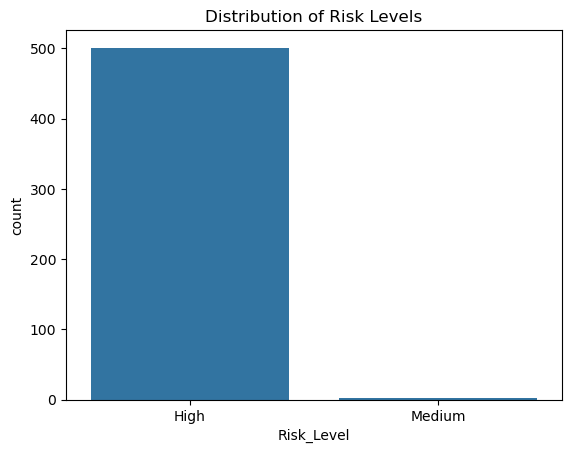

In [19]:
sns.countplot(data=df, x='Risk_Level')
plt.title('Distribution of Risk Levels')
plt.show()

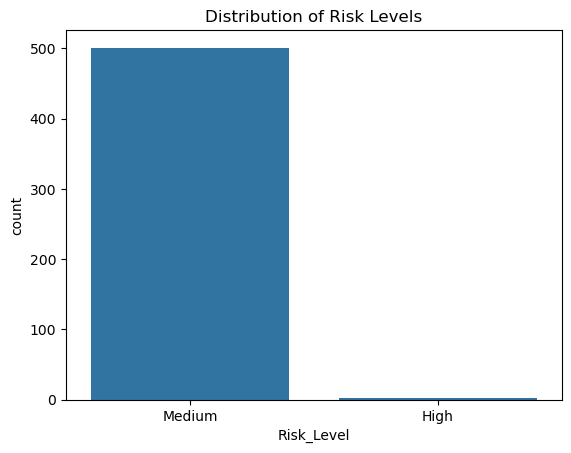

In [20]:
# Function to classify stocks into risk levels based on defined criteria
def classify_risk(row):
    if (row['Volatility'] < 0.2 and
        row['Beta'] < 0.9 and
        row['Debt_to_Equity'] < 50 and
        row['Earnings_Growth'] >= 0.15 and
        row['PE_Ratio'] < 15):
        return 'Low'
    elif (0.35 < row['Volatility'] and
          1.2 < row['Beta'] and
          row['Debt_to_Equity'] >= 200 and
          row['Earnings_Growth'] < 0.05 and
          row['PE_Ratio'] >= 25):
        return 'High'
    else:
        return 'Medium'

# Apply the classification function to each row
df['Risk_Level'] = df.apply(classify_risk, axis=1)
df.head()

sns.countplot(data=df, x='Risk_Level')
plt.title('Distribution of Risk Levels')
plt.show()

### Criteria 2

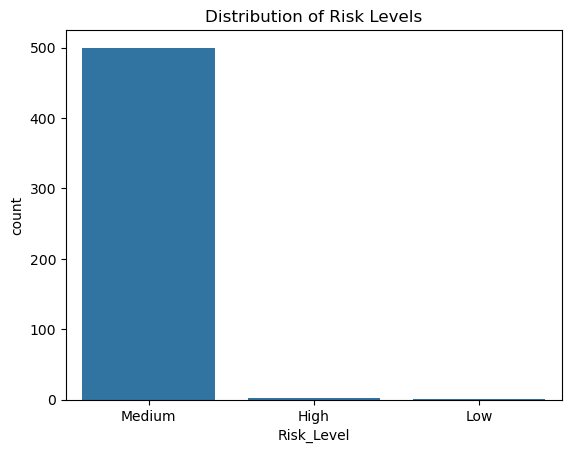

In [21]:
# Define risk classification function
def classify_risk(row):
    if (row['Beta'] <= 0.9 and row['Debt_to_Equity'] <= 50 and row['Earnings_Growth'] >= 0.3 and 
        row['PE_Ratio'] <= 25 and row['Volatility'] <= 0.25):
        return 'Low'
    elif (row['Beta'] > 1.2 and row['Debt_to_Equity'] > 150 and row['Earnings_Growth'] < 0.1 and row['PE_Ratio'] > 35 and row['Volatility'] > 0.35):
        return 'High'
    else:
        return 'Medium'  # Set "Medium Risk" as the default condition

# Apply the classification function to each row
df['Risk_Level'] = df.apply(classify_risk, axis=1)
df.head()

sns.countplot(data=df, x='Risk_Level')
plt.title('Distribution of Risk Levels')
plt.show()


#### Criteria 3
Using only 3 features for now: Volatility, Beta, Debt to Equity

In [22]:
# Define risk classification function
def classify_risk(row):
    if (row['Beta'] <= 0.9 and row['Debt_to_Equity'] <= 50 and row['Volatility'] <= 0.25):
        return 'Low'
    elif (row['Beta'] > 1.2 and row['Debt_to_Equity'] > 150 and row['Volatility'] > 0.35):
        return 'High'
    else:
        return 'Medium'

In [23]:
# Apply the classification function to each row
df['Risk_Level'] = df.apply(classify_risk, axis=1)
df.head()

,Stock,Risk_Level,Industry,Beta,Volatility,Debt_to_Equity,PE_Ratio,Earnings_Growth,MACD,Signal,...,2024-04-17 00:00:00,2024-04-18 00:00:00,2024-04-19 00:00:00,2024-04-22 00:00:00,2024-04-23 00:00:00,2024-04-24 00:00:00,2024-04-25 00:00:00,2024-04-26 00:00:00,2024-04-29 00:00:00,2024-04-30 00:00:00
0,A,Medium,Diagnostics & Research,1.126,0.415880,41.133000,30.829788,0.020000,-1.536634,-1.509291,...,134.550003,132.440002,132.729996,133.910004,139.199997,137.490005,136.369995,137.740005,139.589996,137.039993
1,AAL,High,Airlines,1.580,0.658475,172.687328,16.197184,0.487862,-0.129848,-0.153215,...,13.890000,14.020000,14.110000,14.530000,14.230000,13.920000,14.130000,13.880000,13.980000,13.510000
2,AAPL,Medium,Consumer Electronics,1.264,0.443210,140.968000,29.957165,-0.022000,-0.861375,-1.433049,...,167.772446,166.813736,164.776505,165.615356,166.673920,168.791061,169.659882,169.070679,173.264984,170.099289
3,ABBV,Medium,Drug Manufacturers - General,0.593,0.263340,924.059000,48.131348,4.728000,-2.645659,-2.440588,...,164.250000,164.660004,166.410004,167.889999,169.539993,167.800003,167.289993,159.619995,161.520004,162.639999
4,ABNB,Medium,Travel Services,1.246,0.509936,29.002000,19.427612,1.256000,0.133508,0.029556,...,158.369995,160.100006,155.009995,156.610001,160.949997,162.839996,163.009995,164.229996,162.250000,158.570007


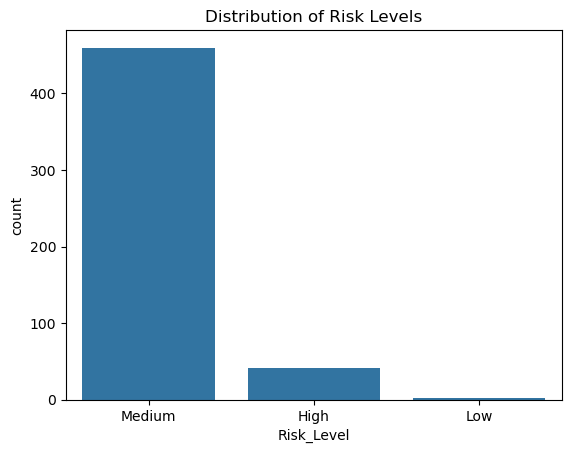

In [24]:
sns.countplot(data=df, x='Risk_Level')
plt.title('Distribution of Risk Levels')
plt.show()

#### Criteria 4 (Based on Brad's previous suggestion)

1. Aggressive Growth - High risk, high reward. Invest in high-growth companies with high volatility. Beta > 1.5, P/E > 30, EPS Growth > 20%.

2. Growth - Invest in companies with strong growth potential. Beta > 1, P/E > 20, EPS Growth > 15%.

3. Balanced - Invest in a mix of growth and value stocks. Beta > 0.8, P/E > 15, EPS Growth > 10%.

4. Conservative - Invest in stable companies with low volatility. Beta < 0.5, P/E < 10, EPS Growth < 5%.

5. Defensive - Invest in defensive stocks that are less affected by economic downturns. Beta < 0.5, P/E < 15, EPS Growth < 10%.

In [25]:
# Define risk classification function
def classify_risk(row):
    if (row['Beta'] < 0.5 and row['Earnings_Growth'] < 0.05 and row['PE_Ratio'] < 10 ):
        return 'Low'
    elif (row['Beta'] > 1.5 or row['PE_Ratio'] > 30 or row['Earnings_Growth'] < 0.2):
        return 'High'
    else:
        return 'Medium'

In [26]:
# Apply the classification function to each row
df['Risk_Level'] = df.apply(classify_risk, axis=1)
df.head()

,Stock,Risk_Level,Industry,Beta,Volatility,Debt_to_Equity,PE_Ratio,Earnings_Growth,MACD,Signal,...,2024-04-17 00:00:00,2024-04-18 00:00:00,2024-04-19 00:00:00,2024-04-22 00:00:00,2024-04-23 00:00:00,2024-04-24 00:00:00,2024-04-25 00:00:00,2024-04-26 00:00:00,2024-04-29 00:00:00,2024-04-30 00:00:00
0,A,High,Diagnostics & Research,1.126,0.415880,41.133000,30.829788,0.020000,-1.536634,-1.509291,...,134.550003,132.440002,132.729996,133.910004,139.199997,137.490005,136.369995,137.740005,139.589996,137.039993
1,AAL,High,Airlines,1.580,0.658475,172.687328,16.197184,0.487862,-0.129848,-0.153215,...,13.890000,14.020000,14.110000,14.530000,14.230000,13.920000,14.130000,13.880000,13.980000,13.510000
2,AAPL,High,Consumer Electronics,1.264,0.443210,140.968000,29.957165,-0.022000,-0.861375,-1.433049,...,167.772446,166.813736,164.776505,165.615356,166.673920,168.791061,169.659882,169.070679,173.264984,170.099289
3,ABBV,High,Drug Manufacturers - General,0.593,0.263340,924.059000,48.131348,4.728000,-2.645659,-2.440588,...,164.250000,164.660004,166.410004,167.889999,169.539993,167.800003,167.289993,159.619995,161.520004,162.639999
4,ABNB,Medium,Travel Services,1.246,0.509936,29.002000,19.427612,1.256000,0.133508,0.029556,...,158.369995,160.100006,155.009995,156.610001,160.949997,162.839996,163.009995,164.229996,162.250000,158.570007


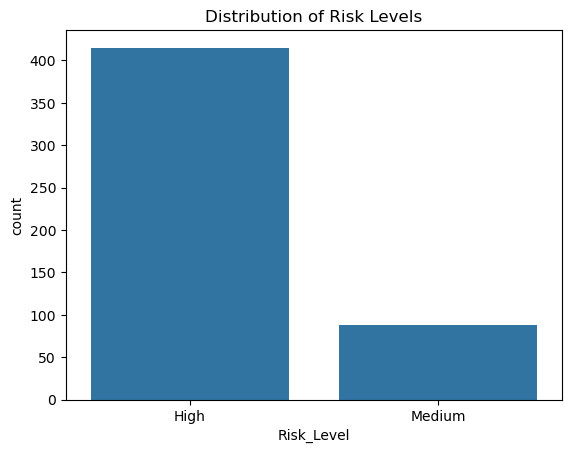

In [27]:
sns.countplot(data=df, x='Risk_Level')
plt.title('Distribution of Risk Levels')
plt.show()

#### Criteria 5

  Stock Risk_Level                      Industry   Beta  Volatility  \
0     A  High Risk        Diagnostics & Research  1.126    0.415880   
1   AAL  High Risk                      Airlines  1.580    0.658475   
2  AAPL  High Risk          Consumer Electronics  1.264    0.443210   
3  ABBV  High Risk  Drug Manufacturers - General  0.593    0.263340   
4  ABNB  High Risk               Travel Services  1.246    0.509936   

   Debt_to_Equity   PE_Ratio  Earnings_Growth      MACD    Signal  ...  \
0       41.133000  30.829788         0.020000 -1.536634 -1.509291  ...   
1      172.687328  16.197184         0.487862 -0.129848 -0.153215  ...   
2      140.968000  29.957165        -0.022000 -0.861375 -1.433049  ...   
3      924.059000  48.131348         4.728000 -2.645659 -2.440588  ...   
4       29.002000  19.427612         1.256000  0.133508  0.029556  ...   

   2024-04-17 00:00:00  2024-04-18 00:00:00  2024-04-19 00:00:00  \
0           134.550003           132.440002           132.72

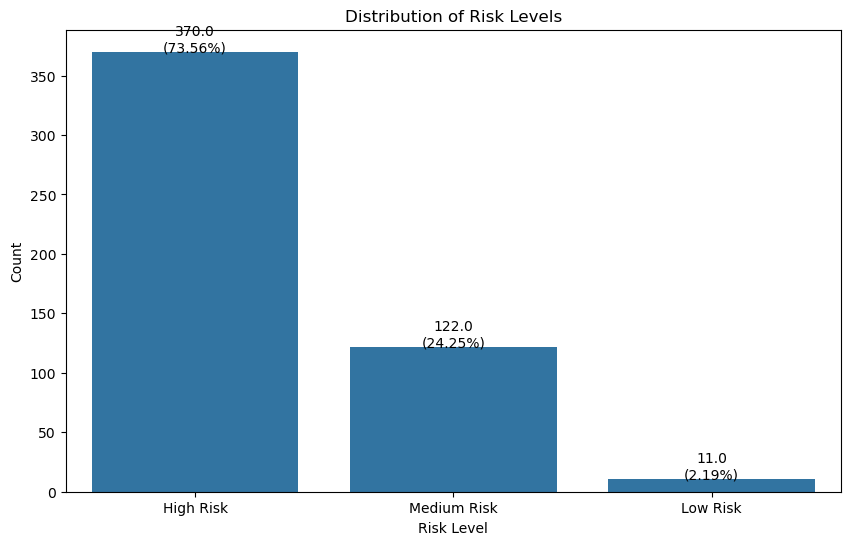

In [28]:
# Define risk classification function
def classify_risk(row):
    if (row['Beta'] <= 1.0 and row['Debt_to_Equity'] <= 100 and row['Earnings_Growth'] >= 0.2 and 
        row['PE_Ratio'] <= 30 and row['Volatility'] <= 0.3):
        return 'Low Risk'
    elif (row['Beta'] > 1.3 or row['Debt_to_Equity'] > 200 or row['Earnings_Growth'] < 0.0 or 
          row['PE_Ratio'] > 40 or row['Volatility'] > 0.4):
        return 'High Risk'
    else:
        return 'Medium Risk'
    
# Apply the classification function to each row
df['Risk_Level'] = df.apply(classify_risk, axis=1)
print(df.head())

# sns.countplot(data=df, x='Risk_Level')
# plt.title('Distribution of Risk Levels')
# plt.show()

# Plot the count of stocks for each risk level
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='Risk_Level', order=df['Risk_Level'].value_counts().index)
plt.title('Distribution of Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Count')

# Add counts and percentages above bars
for p in ax.patches:
    count = p.get_height()
    total = len(df)
    percentage = (count / total) * 100
    ax.annotate(f'{count}\n({percentage:.2f}%)', (p.get_x() + p.get_width() / 2., count),
                ha='center', va='baseline', fontsize=10)

plt.show()

#### Criteria 6
1. Low Risk: Volatility <= 0.3, Beta <= 0.8
2. High Risk: Volatility > 0.4, Beta > 1.2
3. Medium Risk: Rest of the stocks

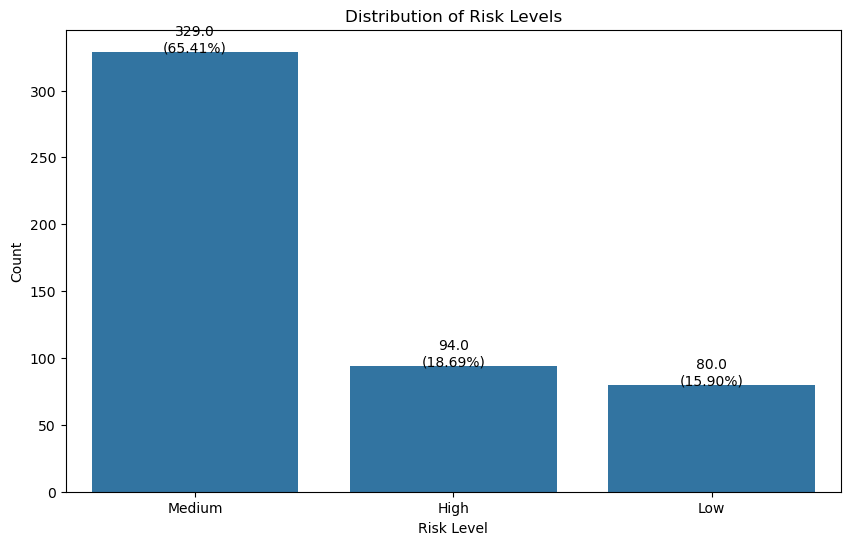

In [29]:
# Define risk classification function
def classify_risk(row):
    if (row['Beta'] <= 0.8 and row['Volatility'] <= 0.3):
        return 'Low'
    elif (row['Beta'] > 1.2 and row['Volatility'] > 0.4):
        return 'High'
    else:
        return 'Medium'
    
# Apply the classification function to each row
df['Risk_Level'] = df.apply(classify_risk, axis=1)

# sns.countplot(data=df, x='Risk_Level')
# plt.title('Distribution of Risk Levels')
# plt.show()

# Plot the count of stocks for each risk level
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='Risk_Level', order=df['Risk_Level'].value_counts().index)
plt.title('Distribution of Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Count')

# Add counts and percentages above bars
for p in ax.patches:
    count = p.get_height()
    total = len(df)
    percentage = (count / total) * 100
    ax.annotate(f'{count}\n({percentage:.2f}%)', (p.get_x() + p.get_width() / 2., count),
                ha='center', va='baseline', fontsize=10)

plt.show()

In [30]:
# Save the updated DataFrame to a new CSV file
df.to_csv('snp_portfolio_final.csv', index=False)

## Recency Checks

### 1. Time-Series Check (RSI and MACD)

In [2]:
def filter_stocks(df, risk_level, rsi_max=30, macd_min=0):
    """
    Filters stocks based on risk level, RSI, and MACD values.
    
    Args:
    df (pd.DataFrame): DataFrame containing stock data.
    risk_level (str): Desired risk level (e.g., 'Low Risk', 'Medium Risk', 'High Risk').
    rsi_max (float): Maximum RSI value for considering a stock.
    macd_min (float): Minimum MACD value for considering a stock.
    
    Returns:
    pd.DataFrame: Filtered DataFrame with stocks that meet the criteria.
    """
    filtered_df = df[df['Risk_Level'] == risk_level]
    # filtered_df = filtered_df[((filtered_df['RSI'] < rsi_max) | 
    #                            (filtered_df['RSI'].between(30, 70))) & 
    #                           (filtered_df['MACD'] > macd_min) & 
    #                           (filtered_df['MACD'] > filtered_df['Signal'])]
    # filtered_df = filtered_df[(filtered_df['RSI'] < 70) & 
    #                           (filtered_df['MACD'] > macd_min)]
    filtered_df = filtered_df[(filtered_df['RSI'] < 70) & 
                              (filtered_df['MACD'] > filtered_df['Signal'])]
    return filtered_df

In [32]:
## Test the function
# Low Risk
filtered_low_risk_stocks = filter_stocks(df, 'Low')
print(df['Risk_Level'].value_counts())
print(filtered_low_risk_stocks['Risk_Level'].value_counts())
print(filtered_low_risk_stocks.describe())


Risk_Level
Medium    329
High       94
Low        80
Name: count, dtype: int64
Risk_Level
Low    50
Name: count, dtype: int64
            Beta  Volatility  Debt_to_Equity    PE_Ratio  Earnings_Growth  \
count  50.000000   50.000000       50.000000   50.000000        50.000000   
mean    0.537420    0.245461      172.955960   27.529243         0.190249   
std     0.164402    0.028826      204.575056   23.958097         0.541397   
min     0.140000    0.193902       24.846000    5.770185        -0.758000   
25%     0.408000    0.221493       93.326000   17.236602        -0.090500   
50%     0.555500    0.245678      139.854000   20.281219         0.087500   
75%     0.671000    0.267633      173.740832   27.880351         0.346000   
max     0.793000    0.299069     1184.314000  139.488890         2.901000   

            MACD     Signal        RSI        EPS  Market_Cap (Millions)  ...  \
count  50.000000  50.000000  50.000000  50.000000              50.000000  ...   
mean    0.033856  

In [33]:
# Medium Risk
filtered_medium_risk_stocks = filter_stocks(df, 'Medium')
print(filtered_medium_risk_stocks['Risk_Level'].value_counts())
print(filtered_medium_risk_stocks.describe())

Risk_Level
Medium    137
Name: count, dtype: int64
             Beta  Volatility  Debt_to_Equity    PE_Ratio  Earnings_Growth  \
count  137.000000  137.000000      137.000000  137.000000       137.000000   
mean     1.004293    0.353992      212.147021   30.338295         0.547379   
std      0.273653    0.085568      713.683640   18.266406         3.459855   
min      0.387000    0.220231        0.693000    5.493285        -0.998000   
25%      0.822000    0.305499       53.982000   17.760977        -0.150000   
50%      1.007000    0.336231       91.568000   28.393164         0.128000   
75%      1.144000    0.378226      172.687328   36.528305         0.487862   
max      1.909000    0.786965     7850.252000  122.257576        39.533000   

             MACD      Signal         RSI         EPS  Market_Cap (Millions)  \
count  137.000000  137.000000  137.000000  137.000000           1.370000e+02   
mean    -0.479423   -0.980375   51.087930    7.009865           1.024822e+05   
std   

In [34]:
# High Risk
filtered_high_risk_stocks = filter_stocks(df, 'High')
print(filtered_high_risk_stocks['Risk_Level'].value_counts())
print(filtered_high_risk_stocks.describe())

Risk_Level
High    39
Name: count, dtype: int64
            Beta  Volatility  Debt_to_Equity    PE_Ratio  Earnings_Growth  \
count  39.000000   39.000000       39.000000   39.000000        39.000000   
mean    1.608128    0.509109      230.302136   37.078261         0.411185   
std     0.383939    0.086320      630.167850   43.109158         1.275033   
min     1.203000    0.401960        0.405000    6.473138        -0.744000   
25%     1.317000    0.445210       31.080000   15.812180        -0.185000   
50%     1.508000    0.481559       85.664000   27.954023         0.309000   
75%     1.772500    0.570420      172.687328   40.361126         0.487862   
max     2.597000    0.737727     3984.371000  245.610290         6.284000   

            MACD     Signal        RSI        EPS  Market_Cap (Millions)  ...  \
count  39.000000  39.000000  39.000000  39.000000           3.900000e+01  ...   
mean   -1.754103  -2.713835  52.090956   5.796923           1.987811e+05  ...   
std     5.02326

In [35]:
# Combine the filtered DataFrames
filtered_stocks = pd.concat([filtered_low_risk_stocks, filtered_medium_risk_stocks, filtered_high_risk_stocks])
print(filtered_stocks['Risk_Level'].value_counts())
print(filtered_stocks.describe())

Risk_Level
Medium    137
Low        50
High       39
Name: count, dtype: int64
             Beta  Volatility  Debt_to_Equity    PE_Ratio  Earnings_Growth  \
count  226.000000  226.000000      226.000000  226.000000       226.000000   
mean     1.005204    0.356748      206.609395   30.879915         0.444865   
std      0.433225    0.112453      620.016077   25.492708         2.755896   
min      0.140000    0.193902        0.405000    5.493285        -0.998000   
25%      0.706000    0.275211       58.142500   17.464260        -0.139500   
50%      0.974500    0.330826      113.260000   25.568736         0.135000   
75%      1.258250    0.408054      172.687328   33.969562         0.487862   
max      2.597000    0.786965     7850.252000  245.610290        39.533000   

             MACD      Signal         RSI         EPS  Market_Cap (Millions)  \
count  226.000000  226.000000  226.000000  226.000000           2.260000e+02   
mean    -0.585833   -1.112701   52.502382    6.498192     

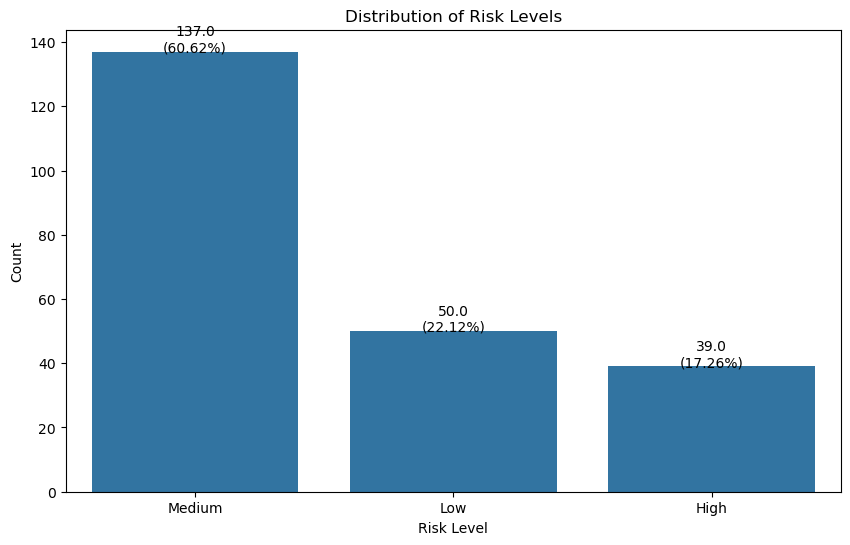

In [37]:
# Plot the count of stocks for each risk level
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=filtered_stocks, x='Risk_Level', order=filtered_stocks['Risk_Level'].value_counts().index)
plt.title('Distribution of Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Count')

# Add counts and percentages above bars
for p in ax.patches:
    count = p.get_height()
    total = len(filtered_stocks)
    percentage = (count / total) * 100
    ax.annotate(f'{count}\n({percentage:.2f}%)', (p.get_x() + p.get_width() / 2., count),
                ha='center', va='baseline', fontsize=10)

plt.show()

In [38]:
# Save the filtered DataFrame to a new CSV file
filtered_stocks.to_csv('snp_portfolio_risk_rsi+macd_filtered.csv', index=False)

## Integrate News Sentiment Analysis

In [9]:
!pip install textblob
!pip install newsapi-python


In [12]:
import requests
from textblob import TextBlob
from newsapi import NewsApiClient

# Function to get news for a given stock symbol
def get_news(stock_symbol):
    try:
        newsapi = NewsApiClient(api_key='your_news_api_key')
        all_articles = newsapi.get_everything(q=stock_symbol, language='en', sort_by='relevancy', page_size=10)
        if all_articles['status'] == 'ok':
            titles = [article['title'] for article in all_articles['articles']]
            return titles
        else:
            print(f"Error fetching news for {stock_symbol}: {all_articles['message']}")
            return []
    except Exception as e:
        print(f"Exception occurred while fetching news for {stock_symbol}: {e}")
        return []

# Function to perform sentiment analysis and make recommendations
def make_recommendations(titles):
    recommendations = []
    for title in titles:
        analysis = TextBlob(title)
        sentiment = 'positive' if analysis.sentiment.polarity >= 0 else 'negative'
        recommendations.append((title, sentiment))
    return recommendations

# Function to filter stocks based on sentiment analysis
def filter_stocks_based_on_sentiment(stock_symbols):
    filtered_stocks = []
    for stock_symbol in stock_symbols:
        titles = get_news(stock_symbol)
        if titles:
            recommendations = make_recommendations(titles)
            negative_count = sum(1 for rec in recommendations if rec[1] == 'negative')
            total_count = len(recommendations)
            negative_percentage = (negative_count / total_count) * 100
            
            if negative_percentage <= 70:
                filtered_stocks.append(stock_symbol)
                print(f"Stock {stock_symbol} passed with {negative_percentage:.2f}% negative news.")
            else:
                print(f"Stock {stock_symbol} failed with {negative_percentage:.2f}% negative news.")
        else:
            filtered_stocks.append(stock_symbol)
            print(f"No titles retrieved or error occurred for {stock_symbol}.")
    
    return filtered_stocks

# Example usage
stock_symbols = {"AAPL", "GOOGL", "MSFT"}
filtered_stocks = filter_stocks_based_on_sentiment(stock_symbols)
print(f"Filtered stocks: {filtered_stocks}")

Exception occurred while fetching news for MSFT: {'status': 'error', 'code': 'apiKeyInvalid', 'message': 'Your API key is invalid or incorrect. Check your key, or go to https://newsapi.org to create a free API key.'}
No titles retrieved or error occurred for MSFT.
Exception occurred while fetching news for GOOGL: {'status': 'error', 'code': 'apiKeyInvalid', 'message': 'Your API key is invalid or incorrect. Check your key, or go to https://newsapi.org to create a free API key.'}
No titles retrieved or error occurred for GOOGL.
Exception occurred while fetching news for AAPL: {'status': 'error', 'code': 'apiKeyInvalid', 'message': 'Your API key is invalid or incorrect. Check your key, or go to https://newsapi.org to create a free API key.'}
No titles retrieved or error occurred for AAPL.
Filtered stocks: ['MSFT', 'GOOGL', 'AAPL']


In [ ]:
# The news sentiment analysis code is in file FinBERT_news_sentiment.ipynb


# Final Portofolio Creation Based on VaR (Value at Risk)

In [ ]:
filtered_stocks = pd.read_csv('snp_portfolio_risk_rsi+macd_filtered.csv')
filtered_stocks.head()

,Stock,Risk_Level,Industry,Beta,Volatility,Debt_to_Equity,PE_Ratio,Earnings_Growth,MACD,Signal,...,2024-04-17 00:00:00,2024-04-18 00:00:00,2024-04-19 00:00:00,2024-04-22 00:00:00,2024-04-23 00:00:00,2024-04-24 00:00:00,2024-04-25 00:00:00,2024-04-26 00:00:00,2024-04-29 00:00:00,2024-04-30 00:00:00
0,ABT,Low,Medical Devices,0.751,0.254556,37.664,31.834892,-0.071,-1.618899,-1.661040,...,105.900002,105.269997,107.279999,107.070000,107.589996,106.889999,106.860001,107.529999,107.269997,105.970001
1,AEE,Low,Utilities - Regulated Electric,0.443,0.216323,148.496,16.827982,-0.011,0.582307,0.485202,...,71.930000,72.510002,73.879997,74.379997,74.019997,74.709999,74.760002,73.660004,74.349998,73.870003
2,AEP,Low,Utilities - Regulated Electric,0.500,0.208203,170.989,16.798883,1.527,0.820753,0.492052,...,80.450737,81.757919,83.381981,84.075188,84.728767,85.530907,86.016144,84.431686,85.827988,85.194206
3,AJG,Low,Insurance Brokers,0.694,0.252395,75.987,51.594707,0.251,-2.659436,-2.695624,...,230.520004,233.990005,236.570007,237.520004,237.869995,236.809998,236.949997,234.110001,233.550003,234.690002
4,ATO,Low,Utilities - Regulated Gas,0.656,0.230843,64.859,17.484161,0.208,0.677511,0.414041,...,114.559998,114.570000,117.199997,118.080002,117.669998,118.660004,118.169998,116.930000,118.639999,117.900002


In [ ]:
filtered_stocks['Risk_Level'].value_counts()

Risk_Level
Medium    137
Low        50
High       39
Name: count, dtype: int64

In [ ]:
filtered_stocks.shape

(226, 2531)

In [ ]:
# Ensure required columns are numeric
filtered_stocks['Beta'] = pd.to_numeric(filtered_stocks['Beta'], errors='coerce')
filtered_stocks['Volatility'] = pd.to_numeric(filtered_stocks['Volatility'], errors='coerce')
filtered_stocks['Debt_to_Equity'] = pd.to_numeric(filtered_stocks['Debt_to_Equity'], errors='coerce')
filtered_stocks['PE_Ratio'] = pd.to_numeric(filtered_stocks['PE_Ratio'], errors='coerce')
filtered_stocks['Earnings_Growth'] = pd.to_numeric(filtered_stocks['Earnings_Growth'], errors='coerce')
filtered_stocks['EPS'] = pd.to_numeric(filtered_stocks['EPS'], errors='coerce')
filtered_stocks['Market_Cap (Millions)'] = pd.to_numeric(filtered_stocks['Market_Cap (Millions)'], errors='coerce')
filtered_stocks['Dividend_Yield'] = pd.to_numeric(filtered_stocks['Dividend_Yield'], errors='coerce')
filtered_stocks['MACD'] = pd.to_numeric(filtered_stocks['MACD'], errors='coerce')
filtered_stocks['Signal'] = pd.to_numeric(filtered_stocks['Signal'], errors='coerce')
filtered_stocks['RSI'] = pd.to_numeric(filtered_stocks['RSI'], errors='coerce')

In [ ]:
# VaR
import itertools

In [ ]:
# Function to calculate daily returns
def calculate_daily_returns(df):
    numeric_columns = df.apply(pd.to_numeric, errors='coerce').select_dtypes(include=[np.number])
    print(f"Numeric columns for returns calculation: {numeric_columns.columns.tolist()}")
    daily_returns = numeric_columns.pct_change().dropna()
    print(f"Daily returns calculated, shape: {daily_returns.shape}")
    return daily_returns


In [ ]:
# Function to calculate Value at Risk (VaR)
def calculate_var(returns, confidence_level=0.95):
    if len(returns) == 0:
        return np.nan
    sorted_returns = np.sort(returns)
    index = int((1 - confidence_level) * len(sorted_returns))
    var = sorted_returns[index]
    return var

In [ ]:
import pandas as pd
import numpy as np
import random

In [ ]:
# Function to get the best portfolio based on VaR
def get_best_portfolio(df, risk_level, num_stocks, sample_size=1000):
    # Filter stocks for particular risk level
    print(f"Filtering stocks for risk level: {risk_level}")
    filtered_df = filter_stocks(df, risk_level)
    
    if filtered_df.empty:
        print("No stocks found after filtering.")
        return None, np.inf
    
    # COMMENTED OUT: Uncomment once news sentiment code is working
    # # Now filter stocks based on news sentiment
    # stock_symbols = filtered_df['Stock'].values
    # filtered_stocks = filter_stocks_based_on_sentiment(stock_symbols)
    # filtered_df = filtered_df[filtered_df['Stock'].isin(filtered_stocks)]

    # Calculate daily returns
    stock_list = filtered_df['Stock'].values
    daily_prices = df.loc[df['Stock'].isin(stock_list)].set_index('Stock').iloc[:, 13:]

    if daily_prices.empty:
        print("No price data available for the filtered stocks.")
        return None, np.inf

    try:
        daily_returns = calculate_daily_returns(daily_prices.T)
        daily_returns = daily_returns.T.reset_index()
        print(f"Daily returns calculated, shape: {daily_returns.shape}")
    except Exception as e:
        print(f"Error calculating daily returns: {e}")
        return None, np.inf

    best_var = np.inf
    best_portfolio = None

    # Randomly sample combinations
    if len(stock_list) < num_stocks:
        print("Not enough stocks to form a portfolio.")
        return None, np.inf
    
    combinations_checked = 0
    for combination in itertools.combinations(stock_list, num_stocks):
        combinations_checked += 1
        if combinations_checked > sample_size:
            break
        selected_stocks = list(combination)
        try:
            if set(selected_stocks).issubset(daily_returns['Stock']):
                portfolio_returns = daily_returns.set_index('Stock').loc[selected_stocks].mean()
                var = calculate_var(portfolio_returns.values)
                if var < best_var:
                    best_var = var
                    best_portfolio = selected_stocks
            else:
                print(f"Skipping combination {selected_stocks} as they are not in daily returns columns.")
        except Exception as e:
            print(f"Error with combination {selected_stocks}: {e}")

    print(f"Total combinations checked: {combinations_checked}")
    return best_portfolio, best_var


#### Medium Risk Level

In [ ]:
portfolio_medium = get_best_portfolio(filtered_stocks, risk_level='Medium', num_stocks=10)
print("Recommended Medium Risk Portfolio:", portfolio_medium)

Filtering stocks for risk level: Medium
Numeric columns for returns calculation: ['ADI', 'AFL', 'AIG', 'AIZ', 'AKAM', 'ALB', 'AMCR', 'AMGN', 'AMT', 'APD', 'APTV', 'AVB', 'AVGO', 'AVY', 'AXON', 'AXP', 'BA', 'BAC', 'BF-B', 'BK', 'BLK', 'BSX', 'BXP', 'C', 'CB', 'CCI', 'CDW', 'CF', 'CFG', 'CHRW', 'CHTR', 'CNC', 'CNP', 'COR', 'COST', 'CPT', 'CSGP', 'CVX', 'DECK', 'DGX', 'DHR', 'DLR', 'DOC', 'DOV', 'DRI', 'EA', 'EIX', 'EL', 'ELV', 'EQR', 'EQT', 'ESS', 'FDS', 'FI', 'FITB', 'FMC', 'FOX', 'FRT', 'GE', 'GEV', 'GL', 'GM', 'GOOG', 'GOOGL', 'GPC', 'GPN', 'GS', 'HAS', 'HD', 'HES', 'HPQ', 'HSIC', 'IDXX', 'INCY', 'INTU', 'INVH', 'IPG', 'IQV', 'IR', 'IRM', 'JPM', 'KIM', 'KMI', 'L', 'LH', 'LHX', 'LMT', 'LW', 'MCK', 'MDT', 'MNST', 'NEM', 'NKE', 'O', 'OKE', 'OMC', 'PANW', 'PCG', 'PNC', 'PODD', 'PPL', 'PWR', 'REG', 'RHI', 'RL', 'RVTY', 'SBUX', 'SNPS', 'SOLV', 'SPGI', 'STE', 'STX', 'SYF', 'SYK', 'SYY', 'TDG', 'TFC', 'TFX', 'TJX', 'TMO', 'TSN', 'TXN', 'UHS', 'UNH', 'UNP', 'UPS', 'VICI', 'VLTO', 'VRTX', 'VST'

#### High Risk Level

In [ ]:
portfolio_high = get_best_portfolio(filtered_stocks, risk_level='High', num_stocks=10)
print("Recommended High Risk Portfolio:", portfolio_high)

Filtering stocks for risk level: High
Numeric columns for returns calculation: ['AAL', 'AAPL', 'ABNB', 'ADBE', 'AMD', 'BBWI', 'BLDR', 'CCL', 'COF', 'DAL', 'DAY', 'DFS', 'ETSY', 'EXPE', 'HWM', 'ILMN', 'KLAC', 'LULU', 'MCHP', 'MHK', 'MPWR', 'MRNA', 'MS', 'NCLH', 'NVDA', 'ON', 'PARA', 'PHM', 'QRVO', 'RCL', 'SWKS', 'TECH', 'TPR', 'TRMB', 'TSLA', 'UAL', 'ULTA', 'URI', 'VTR']
Daily returns calculated, shape: (850, 39)
Daily returns calculated, shape: (39, 851)
Total combinations checked: 1001
Recommended High Risk Portfolio: (['AAL', 'AAPL', 'ABNB', 'ADBE', 'AMD', 'BBWI', 'BLDR', 'CCL', 'NCLH', 'TSLA'], -0.03545860163516208)


#### Low Risk Level

In [ ]:
portfolio_low = get_best_portfolio(filtered_stocks, risk_level='Low', num_stocks=10)
print("Recommended Low Risk Portfolio:", portfolio_low)

Filtering stocks for risk level: Low
Numeric columns for returns calculation: ['ABT', 'AEE', 'AEP', 'AJG', 'ATO', 'AWK', 'CAG', 'CBOE', 'CLX', 'CMS', 'CPB', 'D', 'DTE', 'DUK', 'ED', 'EG', 'ES', 'ETR', 'EVRG', 'EXC', 'FE', 'GIS', 'HII', 'HRL', 'HSY', 'JNJ', 'K', 'LLY', 'LNT', 'MAA', 'MCD', 'MKC', 'MRK', 'MTB', 'NEE', 'NI', 'PEP', 'PM', 'PNW', 'ROL', 'RSG', 'SJM', 'SO', 'SRE', 'T', 'UDR', 'VRSK', 'WBA', 'WEC', 'XEL']
Daily returns calculated, shape: (2516, 50)
Daily returns calculated, shape: (50, 2517)
Total combinations checked: 1001
Recommended Low Risk Portfolio: (['ABT', 'AEE', 'AEP', 'AJG', 'ATO', 'AWK', 'CAG', 'CBOE', 'ES', 'FE'], -0.01542534817079837)
